# Libraries

In [1]:
%matplotlib notebook
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import glob
import random
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Functions

In [2]:
# функции демонстрации изображения
def show_image(img, name):
    plt.figure(name)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

# загрузка всех изображений по пути
def load_images(path):
    filenames = [img for img in glob.glob(path)] 
    filenames.sort()

    assert len(filenames) >= 1
    
    print(filenames)
    
    images = []
    for img_filename in filenames:
        n = cv2.imread(img_filename)
        n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
        n = n.astype('float')
        images.append(n)

    return images, filenames

# фильтрация изображения линейным фильтром
def filter_image(image, vetrical_alignment, horizontal_alignment):
    filtered_image = image.copy().astype('double')

    kernel = np.ones((vetrical_alignment,horizontal_alignment), np.float32) / (vetrical_alignment * horizontal_alignment)
    filtered_image = cv2.filter2D(filtered_image,-1,kernel)
    
    return filtered_image

# фильтрация пиков в изображении медианным фильтром
def filter_peaks_slow(image, kernel_size = 1):
    assert kernel_size >= 1
    
    result_image = np.copy(image)
    for x in range(kernel_size, image.shape[0] - kernel_size):
        for y in range(kernel_size, image.shape[1] - kernel_size):
            values = image[x - kernel_size : x + kernel_size, y - kernel_size : y + kernel_size].copy()
            values[kernel_size, kernel_size] = np.nan
            _max = np.nanmax(values)
            _min = np.nanmin(values)
            if result_image[x, y] > _max or result_image[x, y] < _min:
                # print(x, y)
                result_image[x, y] = np.nanmean(values)
    return result_image




# получение двух границ на изображении в зависимости от положения засветки
# axis = vertical border? 1: 0
def get_borders(image_gap, axis=1):
    img_diff = np.diff(image_gap, axis=axis)

    l_border_val = np.max(img_diff, axis=axis)
    r_border_val = np.min(img_diff, axis=axis)

    _l_border_ind = np.argmax(img_diff, axis=axis)
    _r_border_ind = np.argmin(img_diff, axis=axis)
    
    return _l_border_ind, _r_border_ind


def find_closest_by_brightness(line, value):
    best_fit_index = 0
    temp_delta = np.max(line)
    for ind in range(len(line)):
        cur_delta = abs(line[ind] - value)
        if cur_delta < temp_delta:
            best_fit_index = ind
            temp_delta = cur_delta
    return best_fit_index

def get_borders_a_b(image_gap, slice_size=32):
    half_width = int(image_gap.shape[1] / 2)
    
    image_1st_border = image_gap[:, :half_width]
    image_2nd_border = image_gap[:, half_width:]
    
    a_1st = np.mean(image_1st_border[:, 0:slice_size], axis=1)
    b_1st = np.mean(image_1st_border[:, -slice_size:], axis=1)
    
    a_2nd = np.mean(image_2nd_border[:, 0:slice_size], axis=1)
    b_2nd = np.mean(image_2nd_border[:, -slice_size:], axis=1)
    
    
    border_1st_ind = np.zeros(image_1st_border.shape[0])
    border_2nd_ind = np.zeros(image_2nd_border.shape[0])
    
    for i in range(image_1st_border.shape[0]):
        border_1st_ind[i] = find_closest_by_brightness(image_1st_border[i, :], ((a_1st[i] + b_1st[i]) / 2))
    
    for i in range(image_2nd_border.shape[0]):
        border_2nd_ind[i] = find_closest_by_brightness(image_2nd_border[i, :], ((a_2nd[i] + b_2nd[i]) / 2)) + half_width
    
    
    
    return border_1st_ind, border_2nd_ind

# отрисовка списка границ на изображение
def draw_borders(image, borders):
    _image_with_borders = image.copy().astype('double')
    
    assert type(borders) == list
    
    for border in borders:
        for x in range(len(border)):
            cv2.circle(_image_with_borders, (int(border[x]), x), 0, (255, 0, 0) )
    return _image_with_borders

def draw_borders_color(image, borders):
    _image_with_borders = image.copy().astype('uint8')
    n = cv2.cvtColor(_image_with_borders, cv2.COLOR_GRAY2RGB)
    assert type(borders) == list
    border1 = borders[0]
    for x in range(len(border1)):
        cv2.circle(_image_with_borders, (int(border1[x]), x), 0, (255, 255, 0) )
        
    border2 = borders[1]
    for x in range(len(border2)):
        cv2.circle(_image_with_borders, (int(border2[x]), x), 0, (0, 255, 0) )
    return _image_with_borders

# получение изображения границы с некоторым запасом
def get_border_image(image, border, additional_size=32):
    slice_size = int(border.shape[0] / 10)

    x_down = min( int(np.mean(border[0:slice_size])), int(np.mean(border[-slice_size:]))) - additional_size
    x_up   = max( int(np.mean(border[0:slice_size])), int(np.mean(border[-slice_size:]))) + additional_size
    
    shift = x_down
    
    border_image = np.copy(image[:, x_down : x_up])
    return border_image, shift

# предсказать как проходит линия от точки A до точки B
def predict_line(A, B):
    x = [A[0], B[0]]
    y = [A[1], B[1]]

    coefficients = np.polyfit(x, y, 1)

    
    polynomial = np.poly1d(coefficients)
    x_axis = np.arange(A[0], B[0]) # np.linspace(A[0], B[0])
    y_axis = coefficients[0] * x_axis + coefficients[1]
    return x_axis, y_axis

# получение расширенного изображения по горизонтальной оси
def expand_image(image, expansion_coefficient=10):
    empty_image = np.zeros((image.shape[0], image.shape[1]*expansion_coefficient))
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1] - 1):
            for i in range(expansion_coefficient):
                delta = ((image[y, x + 1] - image[y, x]) / expansion_coefficient)
                empty_image[y, expansion_coefficient * x + i] = image[y, x] + i * delta
    for y in range(image.shape[0]):
        x = image.shape[1] - 1
        for i in range(expansion_coefficient):
            empty_image[y, expansion_coefficient * x + i] = image[y, x]
    
    result_image = empty_image
    return result_image;


def get_4_borders_from_image_fast(image):
    # get image left and right
    half_width = int(image.shape[1] / 2)
    image_left  = image[:, :(half_width)]
    image_right = image[:,  half_width:]
    
    # NO filter peaks on images
    image_left_without_peaks = image_left
    image_right_without_peaks = image_right
    
    # linear filter of images
    filtered_image_left =  filter_image(image_left_without_peaks, vetrical_alignment = 10, horizontal_alignment = 10)
    filtered_image_right = filter_image(image_right_without_peaks, vetrical_alignment = 10, horizontal_alignment = 10)
    
    
    
    # getting borders on images with help of old algorith (на производную)
    left_l_border_ind,  left_r_border_ind  = get_borders(filtered_image_left, 1)
    right_l_border_ind, right_r_border_ind = get_borders(filtered_image_right, 1)

    right_l_border_ind += half_width
    right_r_border_ind += half_width
    
    Additional_size = 32        
    
    shifts = np.zeros(4)
    
    # getting images of borders
    image_of_left_1st_border,  shifts[0] = get_border_image(image, left_l_border_ind,  additional_size=Additional_size)
    image_of_left_2nd_border,  shifts[1] = get_border_image(image, left_r_border_ind,  additional_size=Additional_size)
    image_of_right_1st_border, shifts[2] = get_border_image(image, right_l_border_ind, additional_size=Additional_size)
    image_of_right_2nd_border, shifts[3] = get_border_image(image, right_r_border_ind, additional_size=Additional_size)

    image_of_left_borders = np.hstack((image_of_left_1st_border, image_of_left_2nd_border))
    image_of_right_borders = np.hstack((image_of_right_1st_border, image_of_right_2nd_border))

    
    # filtering images of borders
    image_of_left_borders_without_peaks  = image_of_left_borders
    image_of_right_borders_without_peaks = image_of_right_borders

    image_of_left_borders_filtered  = filter_image(image_of_left_borders_without_peaks,  5, 3)
    image_of_right_borders_filtered = filter_image(image_of_right_borders_without_peaks, 5, 3)
    
    # expanding filtered images of borders
    expanded_image_left_border  = expand_image(image_of_left_borders_filtered,  expansion_coefficient=10)
    expanded_image_right_border = expand_image(image_of_right_borders_filtered, expansion_coefficient=10)
    
    # getting borders with help of (A+B)/2 brightness algorithm
    left_l_border_ind_a_b,  left_r_border_ind_a_b  = get_borders_a_b(expanded_image_left_border)
    right_l_border_ind_a_b, right_r_border_ind_a_b = get_borders_a_b(expanded_image_right_border)
    
#     shifts[1] = shifts[0] + image_of_left_1st_border.shape[0]
#     shifts[3] = shifts[2] + image_of_right_1st_border.shape[0]
    
    left_l_border_ind_a_b  = left_l_border_ind_a_b  / 10 + shifts[0]
    left_r_border_ind_a_b  = left_r_border_ind_a_b  / 10 + shifts[1] - image_of_left_1st_border.shape[1]
    right_l_border_ind_a_b = right_l_border_ind_a_b / 10 + shifts[2]
    right_r_border_ind_a_b = right_r_border_ind_a_b / 10 + shifts[3] - image_of_right_1st_border.shape[1]
    
    return left_l_border_ind_a_b,  left_r_border_ind_a_b, right_l_border_ind_a_b, right_r_border_ind_a_b


def create_simple_approximation(border, slice_size):
    A = [0 + slice_size / 2, np.mean(border[:slice_size])]
    B = [border.shape[0] - slice_size / 2, np.mean(border[-slice_size:])]
    x_axis, y_axis = predict_line(A, B)
    return x_axis, y_axis

def create_complex_approximation(border, slice_size, slice_count):
    x_axis = []
    y_axis = []
    for i in range (slice_count - 1):
        x = slice_size * i
        next_x = x + slice_size
        _A = [x       + slice_size / 2, np.mean(border[x      : (x      + slice_size)])]
        _B = [next_x  + slice_size / 2, np.mean(border[next_x : (next_x + slice_size)])]

        x_axis_cur, y_axis_cur = predict_line(_A, _B)

        x_axis = np.hstack((x_axis, x_axis_cur))
        y_axis = np.hstack((y_axis, y_axis_cur))
    return x_axis, y_axis

def analyze_gap(border_razor, border_tablet, name):
    slice_count = 16
    slice_size = int(border_razor.shape[0] / slice_count)

    tablet_x_axis_simple,  tablet_y_axis_simple  = create_simple_approximation(border_tablet, slice_size)
    tablet_x_axis_complex, tablet_y_axis_complex = create_complex_approximation(border_tablet, slice_size, slice_count)

    razor_x_axis_simple,  razor_y_axis_simple  = create_simple_approximation(border_razor, slice_size)
    razor_x_axis_complex, razor_y_axis_complex = create_complex_approximation(border_razor, slice_size, slice_count)


    factor_mcm = 2.8   # коэффициент перевода в микрометры 
    factor_mm = 2.8 / 1000   # коэффициент перевода в микрометры 

    filter_size = 32
    kernel = np.ones((filter_size, 1), np.float32) / (filter_size * 1)

    # plt.figure("Графики границ " + str(random.random()))
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.minorticks_on()
    #  Определяем внешний вид линий вспомогательной сетки:
    ax.grid(which='minor', color = 'k', linestyle = ':')
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))
    
    # razor
    plt.plot(np.arange(border_razor.shape[0]) * factor_mcm, border_razor * factor_mcm,label='razor data') # linestyle='--', marker='o', markersize=1, 
#     plt.plot(cv2.filter2D(border_razor,-1,kernel) * factor_mcm, label='razor mean data')
    plt.plot(razor_x_axis_simple * factor_mcm,  razor_y_axis_simple  * factor_mcm, label='razor Simple line')
#     plt.plot(razor_x_axis_complex, razor_y_axis_complex * factor_mcm, label='razor complex line')
    razor_filtered_complex = cv2.filter2D(razor_y_axis_complex * factor_mcm,-1,kernel)
    plt.plot(razor_x_axis_complex * factor_mcm, razor_filtered_complex, label='razor mean complex line')

    # tablet
    plt.plot(np.arange(border_tablet.shape[0]) * factor_mcm, border_tablet * factor_mcm, label='tablet data')
#     plt.plot(cv2.filter2D(border_tablet,-1,kernel) * factor_mcm, label='tablet mean data')
    plt.plot(tablet_x_axis_simple * factor_mcm,  tablet_y_axis_simple  * factor_mcm, label='tablet Simple line')
#     plt.plot(tablet_x_axis_complex, tablet_y_axis_complex * factor_mcm, label='tablet complex line')
    tablet_filtered_complex = cv2.filter2D(tablet_y_axis_complex * factor_mcm,-1,kernel)
    plt.plot(tablet_x_axis_complex * factor_mcm, tablet_filtered_complex, label='tablet mean complex line')


    # delta
    delta_data = np.abs(tablet_filtered_complex - razor_filtered_complex)
#     filtered_delta_data = cv2.filter2D(delta_data,-1,kernel)
    plt.plot(np.arange(delta_data.shape[0]) * factor_mcm, delta_data, '-r', label='delta filtered complex')
#     plt.plot(filtered_delta_data * factor, '-g', label='delta mean data')

    plt.ylabel('микрометры')
    plt.xlabel('микрометры') # вертикальные пиксели в изображении

    plt.legend();
    
    plt.grid('on')
    plt.savefig(name + '.png', dpi=800)

def get_brightness(image):
    # get image left and right
    image_left  = image[:, :(int(image.shape[1] / 2))]
    image_right = image[:,  (int(image.shape[1] / 2)):]
    
    # filter peaks on images
    image_left_without_peaks = image_left
    image_right_without_peaks = image_right
    
    # linear filter of images
    filtered_image_left =  filter_image(image_left_without_peaks, vetrical_alignment = 10, horizontal_alignment = 10)
    filtered_image_right = filter_image(image_right_without_peaks, vetrical_alignment = 10, horizontal_alignment = 10)
    
    # getting borders on images with help of old algorith (на производную)
    left_l_border_ind,  left_r_border_ind  = get_borders(filtered_image_left, 1)
    right_l_border_ind, right_r_border_ind = get_borders(filtered_image_right, 1)

    Additional_size = 32    
    
    # getting images of borders
    image_of_left_1st_border  = get_border_image(image, left_l_border_ind,  additional_size=Additional_size)
    image_of_left_2nd_border  = get_border_image(image, left_r_border_ind,  additional_size=Additional_size)
    image_of_right_1st_border = get_border_image(image, right_l_border_ind, additional_size=Additional_size)
    image_of_right_2nd_border = get_border_image(image, right_r_border_ind, additional_size=Additional_size)
    
    brightness = np.zeros(8)
    
    
    number = np.mean(image_of_left_1st_border[:, ])
    
def analyze_derivative(image, axis, name):
    # plt.figure("derivative analyzation " + str(random.random()))
    img_diff = np.diff(image.astype('float'), axis=axis)
    _max = np.max(img_diff)
    img_diff = np.abs(img_diff * 255 / _max)
    return img_diff
    # cv2.imwrite(name + '.png', img_diff)

## Load images

In [41]:
# Photo/27_01_2020_Process/*.bmp
# Photo/200122__2gaps_Binning2/*.bmp
original_images, images_names = load_images("Photo/2020_02_07/*.bmp")

assert len(original_images) > 0

print("found " + str(len(original_images)) + " images" )

['Photo/2020_02_07\\200205-obr8170um-26db-19-10.bmp', 'Photo/2020_02_07\\200205-obr8170um-28db-19-12.bmp']
found 2 images


## Taking 1 image

In [42]:
number = 1

original_image = original_images[number].copy()
im_name = images_names[number]

## Getting borders

In [43]:
%%time
border_1,border_2,border_3,border_4 = get_4_borders_from_image_fast(original_image)

Wall time: 15.6 s


<IPython.core.display.Javascript object>


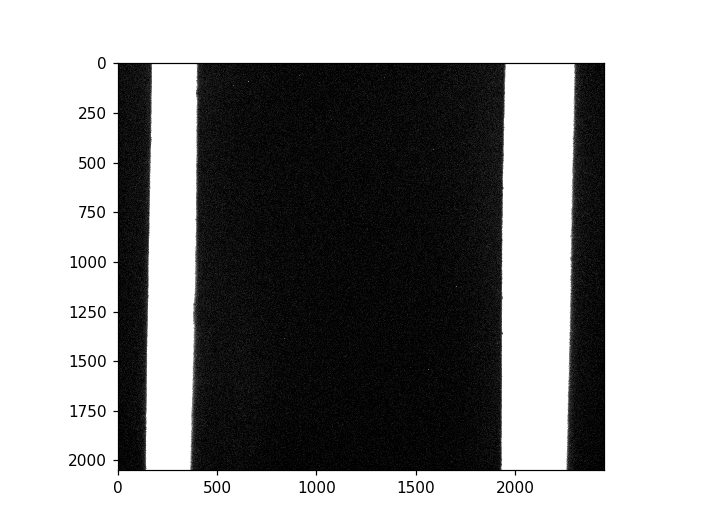

In [37]:
show_image(original_image, 'start image')

## Show borders

[398.1 398.1 398.1 ... 365.9 365.9 366. ]


<IPython.core.display.Javascript object>


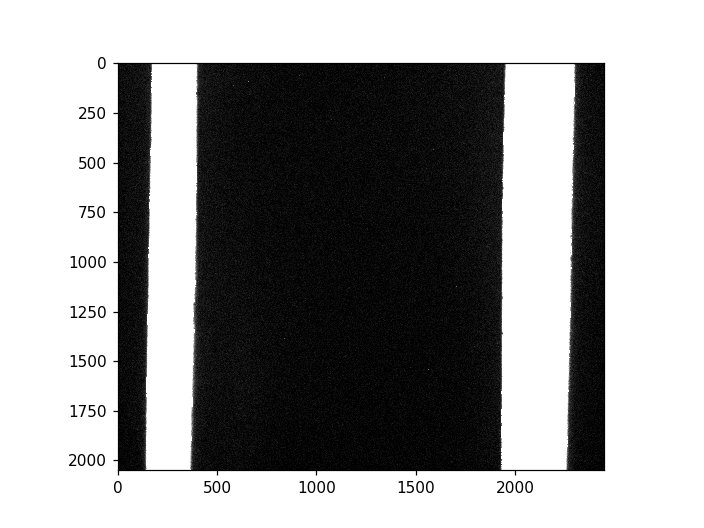

In [38]:
borders = []
borders.append(border_1)
borders.append(border_2)
borders.append(border_3)
borders.append(border_4)

print(border_2)

new_image = draw_borders(original_image,borders)
plt.figure('show image with borders')
plt.imshow(new_image, cmap = 'gray', vmin=0, vmax=255)

<IPython.core.display.Javascript object>


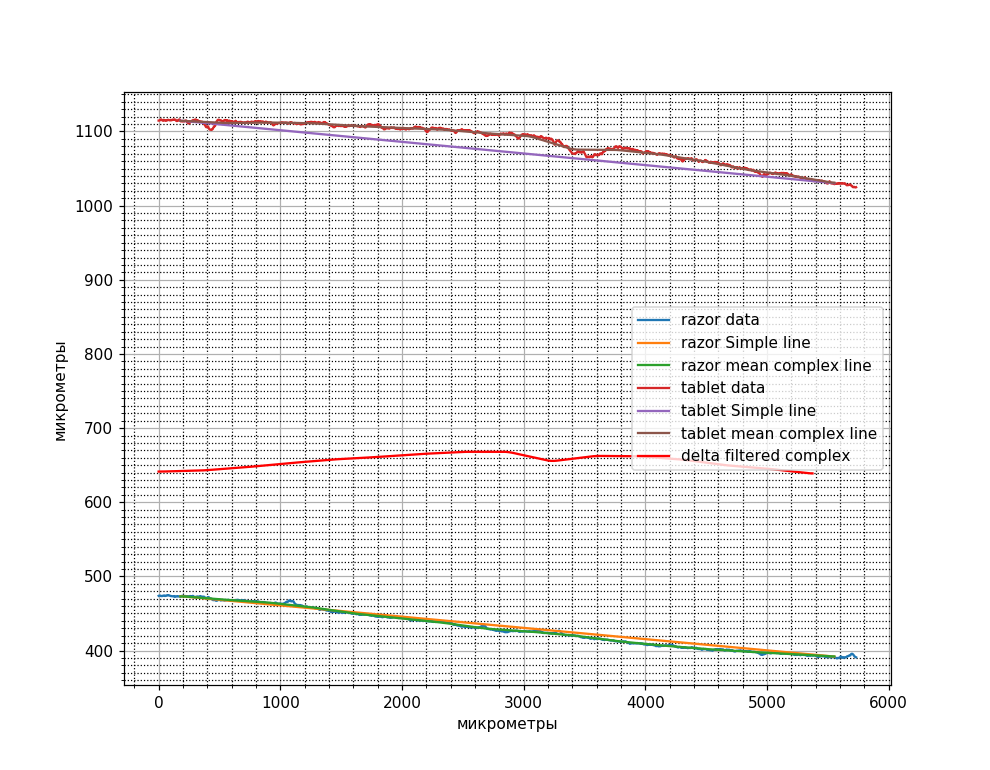

In [39]:
analyze_gap(border_razor=border_1, border_tablet=border_2, name=im_name[:-4])

<IPython.core.display.Javascript object>


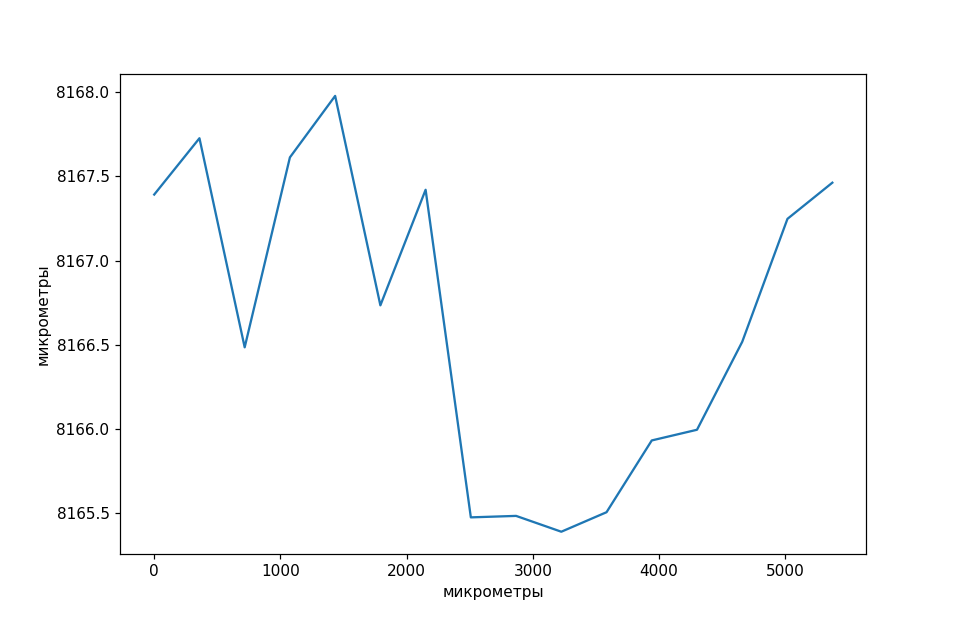

In [44]:
# border_1, border_2, border_3, border_4

slice_count = 16
slice_size = int(border_1.shape[0] / slice_count)

x_axis_complex, tablet_1_y_axis_complex = create_complex_approximation(border_2, slice_size, slice_count)
x_axis_complex, razor_1_y_axis_complex = create_complex_approximation(border_1, slice_size, slice_count)
delta_data_1 = np.abs(tablet_1_y_axis_complex - razor_1_y_axis_complex)

x_axis_complex, tablet_2_y_axis_complex = create_complex_approximation(border_3, slice_size, slice_count)
x_axis_complex, razor_2_y_axis_complex = create_complex_approximation(border_4, slice_size, slice_count)
delta_data_2 = np.abs(tablet_2_y_axis_complex - razor_2_y_axis_complex)

factor_mcm = 2.8   # коэффициент перевода в микрометры 

plt.figure('Diametr')
plt.ylabel('микрометры')
plt.xlabel('микрометры') # вертикальные пиксели в изображении
plt.plot(np.arange(delta_data_2.shape[0]) * factor_mcm, table + (9845 - (delta_data_2 + delta_data_1) * factor_mcm))

In [18]:
table = 8170 - (9845 - (delta_data_2 + delta_data_1) * factor_mcm)

<IPython.core.display.Javascript object>


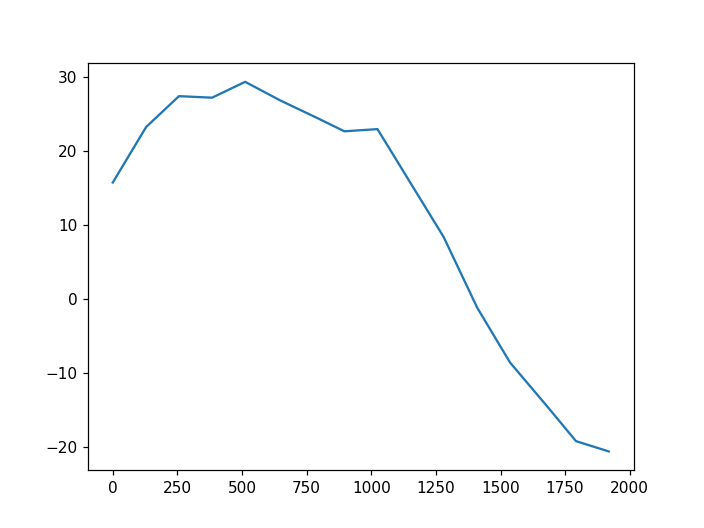

In [26]:
plt.figure('table')
plt.plot(table)

<IPython.core.display.Javascript object>


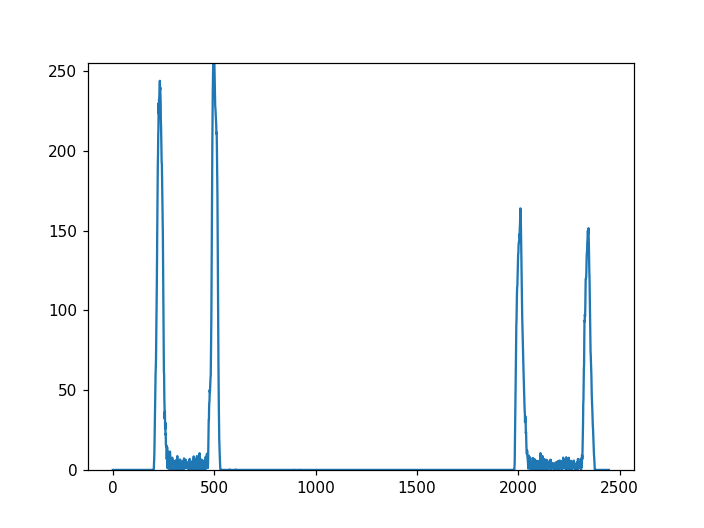

In [10]:
fil_im = filter_image(original_image, vetrical_alignment = 30, horizontal_alignment = 30)
img_der = analyze_derivative(fil_im, axis=1, name=im_name[:-4] + "_derivative")
plt.figure('der')
plt.ylim(0, 255)
plt.plot(img_der[1000, :])

In [11]:
# for i in range(len(original_images)):
#     # taking current image
#     cur_image = original_images[i].copy()
#     image_name = images_names[i]
    
#     border_1,border_2,border_3,border_4 = get_4_borders_from_image_fast(cur_image)
    
#     analyze_gap(border_1, border_2, image_name[:-4] + "_left")
#     analyze_gap(border_4, border_3, image_name[:-4] + "_right")
    
#     analyze_derivative(cur_image, axis=1, name=image_name[:-4] + "_derivative")
    
#     # analyze_brightness